Phantom Examples

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import normalized_root_mse
from skimage.restoration import unwrap_phase
from time import perf_counter

from mssfp.simulations import ssfp, add_noise_gaussian
from mssfp.phantoms import tissue_map, shepp_logan, generate_ssfp_dataset, load_dataslice, generate_offres, generate_phantom, get_phantom_parameters
from mssfp.recons import gs_recon, planet
from mssfp.plots import plot_dataset, plot_planet_results

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]

Generating 3d phantom:(1, 434, 362)


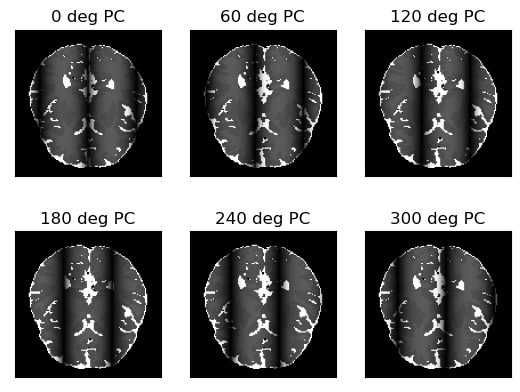

In [2]:
data = generate_ssfp_dataset(N=128, npcs=6, f=500, alpha=np.deg2rad(60), sigma=0, data_indices=[1, 150])['M']
plot_dataset(data, slice=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]

Generating 3d phantom:(1, 434, 362)


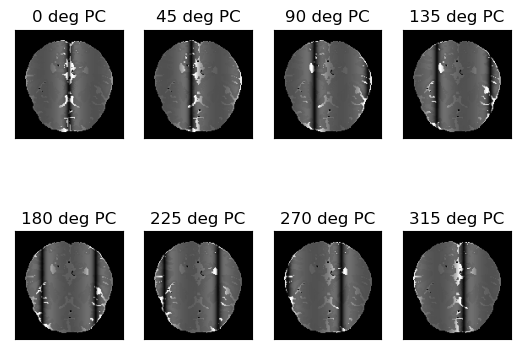

Took 1.09142 sec to run PLANET
(128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128) (128, 128) (128, 128, 1)


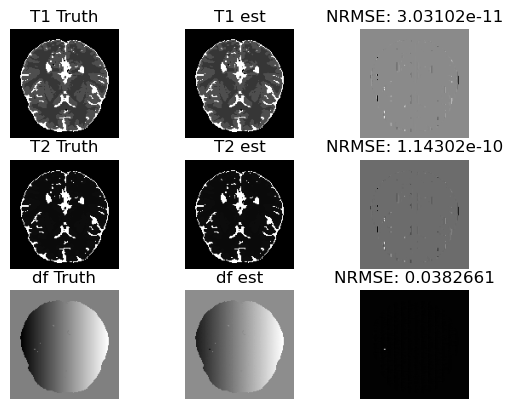

In [3]:
TR = 3e-3
TE = TR / 2
freq = 1 / 3e-3
alpha = np.deg2rad(15)
data = generate_ssfp_dataset(N=128, npcs=8, f=freq, alpha=alpha, TR=TR, TE=TE, sigma=0, data_indices=[1, 150])
plot_dataset(data['M'])

T1 =  np.squeeze(data['phantom']['t1_map'])
T2 =  np.squeeze(data['phantom']['t2_map'])
df =  np.squeeze(data['phantom']['offres'])

M =  np.squeeze(data['M'])
M = np.transpose(M, (2,0,1))
M = M[...,None]

M0 =  np.squeeze(data['phantom']['M0'])
mask = np.abs(M0) > 1e-8
mask = mask[...,None]

# Do the thing
t0 = perf_counter() 
Mmap, T1est, T2est, dfest = planet(M, alpha, TR, mask=mask, pc_axis=0)
print('Took %g sec to run PLANET' % (perf_counter() - t0))

# Look at a single slice

print(T1est.shape, T2est.shape, dfest.shape, T1.shape, T2.shape, mask.shape)
sl = 0
T1est = T1est[..., sl]
T2est = T2est[..., sl]
dfest = dfest[..., sl]
mask = mask[..., sl]

# Simple phase unwrapping of off-resonance estimate
dfest = unwrap_phase(dfest*2*np.pi*TR)/(2*np.pi*TR)

plot_planet_results(mask, T1, T1est, T2, T2est, df, dfest)

In [4]:
print(M.shape)
print(alpha)
print(TR)
print(T1.shape)
print(mask.shape)
t1 = [M, alpha, TR, mask]

(8, 128, 128, 1)
0.2617993877991494
0.003
(128, 128)
(128, 128)


(8, 128, 128, 1) 0.2617993877991494 0.003 (128, 128, 1)


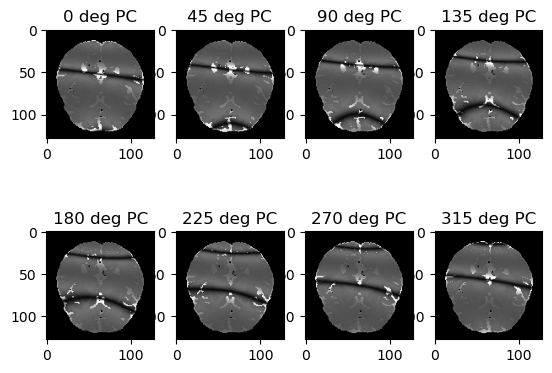

In [5]:
N = 128; npcs = 8 
filepath = '../data'
data = load_dataslice(filepath, image_index=1, slice_index=150)

freq = 1 / 3e-3
offres = generate_offres(N, f=freq, rotate=True, deform=True) 

# alpha = flip angle
alpha = np.deg2rad(15)

#Create brain phantom
phantom = generate_phantom(data, alpha, offres=offres)

#Get phantom parameter
M0, T1, T2, _alpha, df, _sample = get_phantom_parameters(phantom)

# Generate phase-cycled images 
TR = 3e-3
TE = TR / 2
pcs = np.linspace(0, 2 * np.pi, npcs, endpoint=False)
M = ssfp(T1, T2, TR, TE, alpha, f0=-df, dphi=pcs, M0=M0)
#_M = add_noise_gaussian(M, sigma=0.0001)
M = np.transpose(M, (2,0,1))
M = M[...,None]

# Do T1, T2 mapping for each pixel
mask = np.abs(M0) > 1e-8
mask = mask[...,None]
M = M * mask

print(M.shape, alpha, TR, mask.shape)

# Show the phase-cycled images
nx, ny = 2, 4
plt.figure()
for ii in range(nx*ny):
    plt.subplot(nx, ny, ii+1)
    plt.imshow(np.abs(M[ii, :, :, 0]))
    plt.title('%d deg PC' % (ii*(360/npcs)))
plt.show()

In [6]:
print(M.shape)
print(alpha)
print(TR)
print(T1.shape)
print(mask.shape)
t2 = [M, alpha, TR, mask]

(8, 128, 128, 1)
0.2617993877991494
0.003
(128, 128)
(128, 128, 1)


Took 1.07479 sec to run PLANET
(128, 128, 1) (128, 128, 1) (128, 128, 1) (128, 128) (128, 128) (128, 128, 1)
t1, mask: (128, 128) (128, 128)


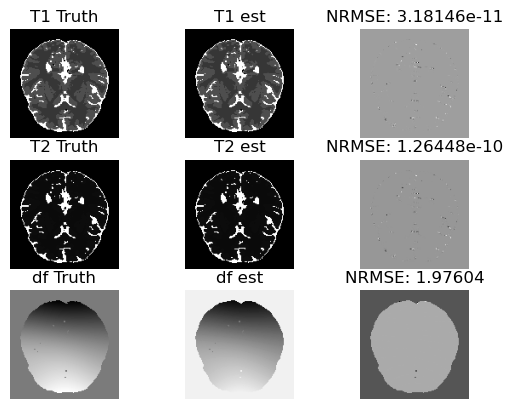

In [7]:
# Do the thing
t0 = perf_counter() 
Mmap, T1est, T2est, dfest = planet(M, alpha, TR, mask=mask, pc_axis=0)
print('Took %g sec to run PLANET' % (perf_counter() - t0))

# Look at a single slice

print(T1est.shape, T2est.shape, dfest.shape, T1.shape, T2.shape, mask.shape)
sl = 0
T1est = T1est[..., sl]
T2est = T2est[..., sl]
dfest = dfest[..., sl]
#T1 = T1[..., sl]
#T2 = T2[..., sl]
mask = mask[..., sl]

# Simple phase unwrapping of off-resonance estimate
dfest = unwrap_phase(dfest*2*np.pi*TR)/(2*np.pi*TR)

print('t1, mask:', T1.shape, mask.shape)

nx, ny = 3, 3
plt.subplot(nx, ny, 1)
plt.imshow(T1*mask)
plt.title('T1 Truth')
plt.axis('off')

plt.subplot(nx, ny, 2)
plt.imshow(T1est)
plt.title('T1 est')
plt.axis('off')

plt.subplot(nx, ny, 3)
plt.imshow(T1*mask - T1est)
plt.title('NRMSE: %g' % normalized_root_mse(T1, T1est))
plt.axis('off')

plt.subplot(nx, ny, 4)
plt.imshow(T2*mask)
plt.title('T2 Truth')
plt.axis('off')

plt.subplot(nx, ny, 5)
plt.imshow(T2est)
plt.title('T2 est')
plt.axis('off')

plt.subplot(nx, ny, 6)
plt.imshow(T2*mask - T2est)
plt.title('NRMSE: %g' % normalized_root_mse(T2, T2est))
plt.axis('off')

plt.subplot(nx, ny, 7)
plt.imshow(df*mask)
plt.title('df Truth')
plt.axis('off')

plt.subplot(nx, ny, 8)
plt.imshow(dfest)
plt.title('df est')
plt.axis('off')

plt.subplot(nx, ny, 9)
plt.imshow(df*mask - dfest)
plt.title('NRMSE: %g' % normalized_root_mse(df*mask, dfest))
plt.axis('off')

plt.show()